In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
!curl -L https://anaconda.org/conda-forge/gudhi/3.1.1/download/linux-64/gudhi-3.1.1-py36hd3ef239_1.tar.bz2 | tar xj
!mv lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
import gudhi
from matplotlib import cm
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3781    0  3781    0     0   6963      0 --:--:-- --:--:-- --:--:--  6963
100 3217k  100 3217k    0     0  1546k      0  0:00:02  0:00:02 --:--:-- 3501k


In [ ]:
!pip install kaggle
api_token = {"username":"ignasisanchez","key":"79ae11ad5532231e882297d5df83de82"}
import json
import zipfile
import os
!mkdir /root/.kaggle
!echo '{"username":"ignasisanchez","key":"79ae11ad5532231e882297d5df83de82"}' > /root/.kaggle/kaggle.json
!chmod 600 /content/.kaggle/kaggle.json
!kaggle config path -p /content
!kaggle datasets download -d shayanfazeli/heartbeat
!unzip heartbeat.zip

chmod: cannot access '/content/.kaggle/kaggle.json': No such file or directory
usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
 99% 98.0M/98.8M [00:01<00:00, 50.2MB/s]
100% 98.8M/98.8M [00:01<00:00, 55.5MB/s]
Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


In [ ]:
data=pd.read_csv('mitbih_train.csv', header=None)

X = data[data.columns.values[:-1]]
y = data[data.columns.values[-1]]

# Persistence functions

In [ ]:
def getPersistence(vec, clean=True):
  """
  This transforms the 1D time series vec into a persistence diagram.
  """
  simplex_up = gudhi.SimplexTree()
  simplex_dw = gudhi.SimplexTree()
  # Fullfill the simplexes
  for i in np.arange(len(vec)): 
    simplex_up.insert([i], filtration=vec[i])
    simplex_dw.insert([i], filtration=-vec[i])
  for i in np.arange(len(vec)-1): 
    simplex_up.insert([i, i+1], filtration=vec[i])
    simplex_dw.insert([i, i+1], filtration=-vec[i])
  # Initialize the filtrations
  simplex_up.initialize_filtration()
  simplex_dw.initialize_filtration()


  dig_up = simplex_up.persistence()
  dig_dw = simplex_dw.persistence()

  if clean:
    dig_up = np.asarray([[ele[1][0], ele[1][1]] for ele in dig_up if ele[1][1] < np.inf])
    dig_dw = np.asarray([[ele[1][0], ele[1][1]] for ele in dig_dw if ele[1][1] < np.inf])

  return dig_up, dig_dw, simplex_up, simplex_dw

In [ ]:
persistence = [getPersistence(X.iloc[i].to_numpy(), num_points=100, clean=False) for i in tqdm(range(X.shape[0]))]
diag = [x[0] for x in persistence]

# Necessary functions to compute the reconstruction of a function from three persistence diagrams

In [ ]:
def intersect(theta1, theta2, s0, w0):
  return np.array([-1./np.sin(theta1 - theta2) * (-np.cos(theta2)*s0 + np.cos(theta1)*w0), 1./np.sin(theta1 - theta2) * (-np.sin(theta2)*s0 + np.sin(theta1)*w0)])

def line(theta, p, x):
  if theta != 0:
    return -np.tan(theta)*x + p/np.cos(theta)
  else:
    return np.tan(theta)*x + np.cos(theta)*p

def transform_rotate(original, x, theta):
  uwu = np.vstack((x, np.array(original)))
  owo = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
  ewe = np.dot(owo, uwu)
  return ewe

In [ ]:
def get_points_diagrams(X, x, theta0, theta1, theta2):
  X_rot0 = transform_rotate(X, x, theta0)
  X_rot1 = transform_rotate(X, x, theta1)
  X_rot2 = transform_rotate(X, x, theta2)

  pers0 = getPersistence(X, clean=False)
  pers1 = getPersistence(X_rot1[1], clean=False)
  pers2 = getPersistence(X_rot2[1], clean=False)

  mins_0 = sorted([pers0[0][i][1][0] for i in range(len(pers0[0]))])
  mins_1 = sorted([pers1[0][i][1][0] for i in range(len(pers1[0]))])
  mins_2 = sorted([pers2[0][i][1][0] for i in range(len(pers2[0]))])

  maxs_0 = sorted([pers0[0][i][1][1] for i in range(1, len(pers0[0]))])
  maxs_1 = sorted([pers1[0][i][1][1] for i in range(1, len(pers1[0]))])
  maxs_2 = sorted([pers2[0][i][1][1] for i in range(1, len(pers2[0]))])

  return sorted(mins_0 + maxs_0, reverse=True), sorted(mins_1 + maxs_1), sorted(mins_2 + maxs_2)

def reconstruct_signal(X, x, theta0, theta1, theta2):
  init = np.array([x[0], X[0]])
  end = np.array([x[-1], X[-1]])
  
  T, S, R = get_points_diagrams(X, x, theta0, theta1, theta2)

  crit= [init, end]
  for s in S:
    i = 0
    j = 0
    foundTriple = False
    while (not foundTriple) and (i < len(R)) and (j < len(T)):
      pr = intersect(theta1, theta2, s, R[i])
      pt = intersect(theta1, theta0, s, T[j])    
      if (np.linalg.norm(pr-pt)) < 1e-6:
        foundTriple = True
        crit.append(pr)
      elif pr[0] < pt[0]:
        i+=1
      else:
        j+=1         

  xxxx = np.array([m[0] for m in crit])
  yyyy = np.array([m[1] for m in crit])
  idx = np.argsort(xxxx)
  xxxx = xxxx[idx]
  yyyy = yyyy[idx]

  return xxxx, yyyy

def reconstruct_signal_step(X, x, theta0, theta1, theta2):
  T, S, R = get_points_diagrams(X, x, theta0, theta1, theta2)

  colors0 = cm.Greens(np.linspace(0, 1, num=len(T)+3))
  colors1 = cm.Reds(np.linspace(0, 1, num=len(S)+3))
  colors2 = cm.Purples(np.linspace(0, 1, num=len(R)+3))

  ims = []
  crit= []
  for s in range(len(S)):
    i = 0
    j = 0
    foundTriple = False
    while (not foundTriple) and (i < len(R)) and (j < len(T)):
      pr = intersect(theta1, theta2, S[s], R[i])
      pt = intersect(theta1, theta0, S[s], T[j])
      fig = plt.figure(figsize=(15, 10))
      for ss in range(0, len(S)):
        plt.plot(x, line(theta0, T[ss], x), color=colors0[ss+3], alpha=0.15)
        plt.plot(x, line(theta1, S[ss], x), color=colors1[ss+3], alpha=0.15)
        plt.plot(x, line(theta2, R[ss], x), color=colors2[ss+3], alpha=0.15)
      plt.plot(x, X, color='k')
      plt.plot(x, line(theta1, S[s], x), color=colors1[s+3], alpha=1)
      plt.plot(x, line(theta0, T[j], x), color=colors0[j+3], alpha=1)   
      plt.plot(x, line(theta2, R[i], x), color=colors2[i+3], alpha=1)
      plt.plot(pr[0], pr[1], '*', color='m')
      plt.plot(pt[0], pt[1], '*', color='y')
      plt.xlim(-0.05,1.05)
      if (np.linalg.norm(pr-pt)) < 1e-6:
        foundTriple = True
        crit.append(pr)
      elif pr[0] < pt[0]:
        i+=1
      else:
        j+=1

  plt.xlim(-0.05, 1.05)
  plt.ylim(-0.05, 1.05)
  anims = animation.ArtistAnimation(fig, ims, interval=400, blit=False, repeat_delay=0)
  plt.show()               

  xxxx = np.array([m[0] for m in crit])
  yyyy = np.array([m[1] for m in crit])
  idx = np.argsort(xxxx)
  xxxx = xxxx[idx]
  yyyy = yyyy[idx]

  return xxxx, yyyy

def reconstruct_signal_naive(X, x, theta0, theta1, theta2):
  T, S, R = get_points_diagrams(X, x, theta0, theta1, theta2)
  crit = []
  for t in T:
    for r in R:
      for s in S:
        p1 = intersect(theta0, theta2, t, r)
        p2 = intersect(theta0, theta1, t, s)

        if (np.linalg.norm(p1-p2)) < 1e-6:
          crit.append(p1)

  xxxx = np.array([m[0] for m in crit])
  yyyy = np.array([m[1] for m in crit])
  idx = np.argsort(xxxx)
  xxxx = xxxx[idx]
  yyyy = yyyy[idx]

  return xxxx, yyyy


We can test the reconstruction algorithm with a heartbeat

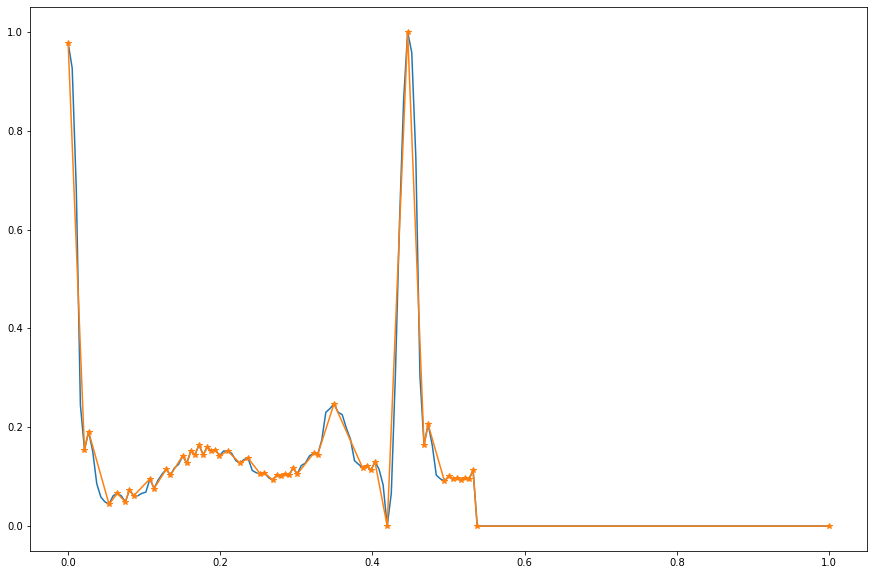

In [ ]:
x = np.linspace(0, 1, 187)
theta0 = 0
theta1 =  5 * np.pi / 180
theta2 =  10 * np.pi / 180


xx, yy = reconstruct_signal(np.array(X.iloc[0]), x, theta0, theta1, theta2)
plt.figure(figsize=(15, 10))
plt.plot(x, X.iloc[0])
plt.plot(xx, yy, "*-")
plt.show()

In order to test the times of the naive algorithm versus the optimized algorithm, we need to have a set of functions with a predefined number of critical values. For that reason, we coded a function that creates a signal with the desired number of critical points. We check that the algorithm is properly reconstructing such signals.

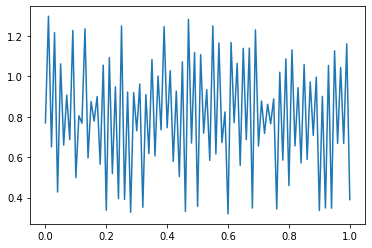

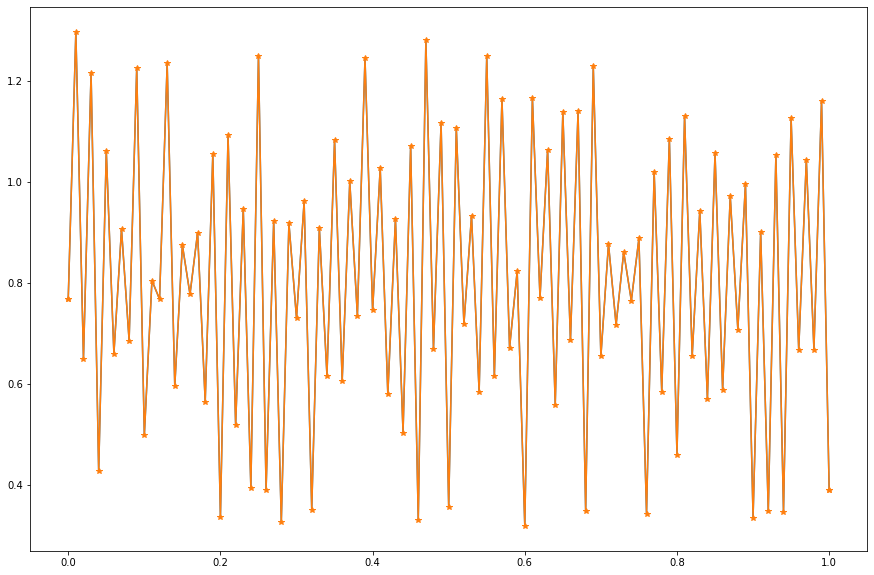

In [ ]:
def create_function(num_points):
  fun = np.zeros(num_points)
  for i in range(num_points):
    if i%2 == 0:
      fun[i] = 0.3 + np.random.uniform(0, 0.5, 1)
    else:
      fun[i] = 0.8 + np.random.uniform(0, 0.5, 1)
  return fun

ff = create_function(101)
plt.plot(np.linspace(0, 1, 101), ff)
x = np.linspace(0, 1, 101)
theta0 = 0
theta1 =  5 * np.pi / 180
theta2 =  10 * np.pi / 180


xx, yy = reconstruct_signal(ff, x, theta0, theta1, theta2)
plt.figure(figsize=(15, 10))
plt.plot(x, ff)
plt.plot(xx, yy, "*-")
plt.show()

Now we can test the times that both algorithms take. 

In [ ]:
import time
theta0 = 0
theta1 = - 5 * np.pi / 180
theta2 = - 10 * np.pi / 180


points = [5, 10, 25, 50, 100, 150, 200]
time_naive = []
time_heur = []

for p in tqdm(points):
  x = np.linspace(0, 1, p)
  X = create_function(x, p)

  t0 = time.time()
  reconstruct_signal_naive(X, x, theta0, theta1, theta2)
  t1 = time.time()
  time_naive.append(t1 - t0)

  t0 = time.time()
  reconstruct_signal(X, x, theta0, theta1, theta2)
  t1 = time.time()
  time_heur.append(t1 - t0)

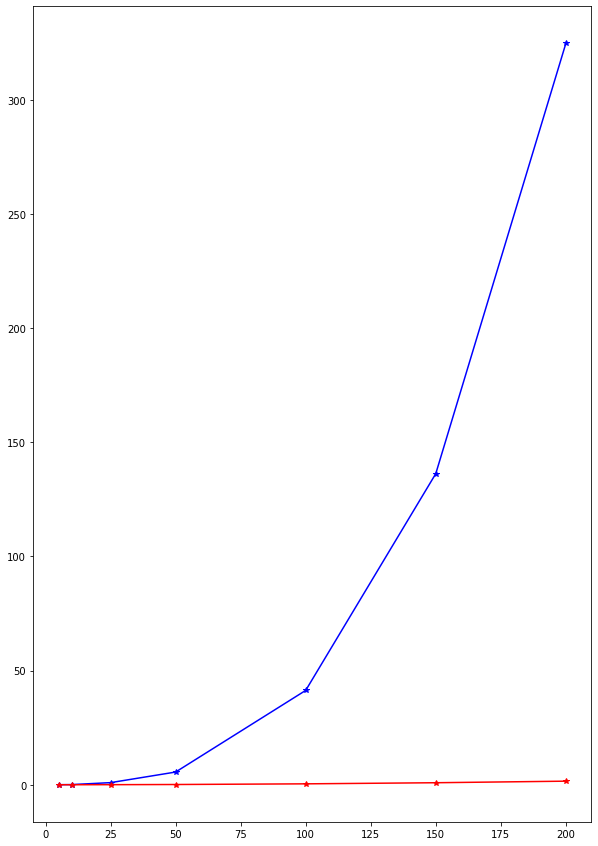

[0.020604372024536133, 0.06756305694580078, 0.9243342876434326, 5.562572717666626, 41.31985902786255, 136.26065731048584, 324.72052335739136] [0.001743316650390625, 0.0058002471923828125, 0.02603745460510254, 0.10293936729431152, 0.39473605155944824, 0.8799753189086914, 1.5653882026672363]


In [ ]:
plt.figure(figsize=(10, 15))
plt.plot(points, time_naive, '*-', color='b')
plt.plot(points, time_heur, '*-', color='r')
plt.show()
print(time_naive, time_heur)

Finally, we made a function that plots step by step what the reconstructing algorithm is doing. This serves as an illustrative process to understand what is happening behind the computations. It also can be used to create an animation.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

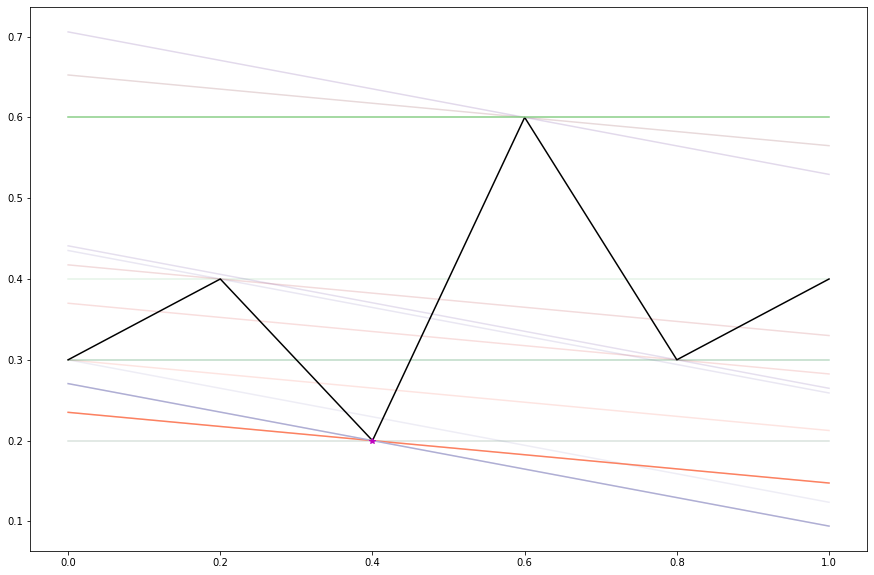

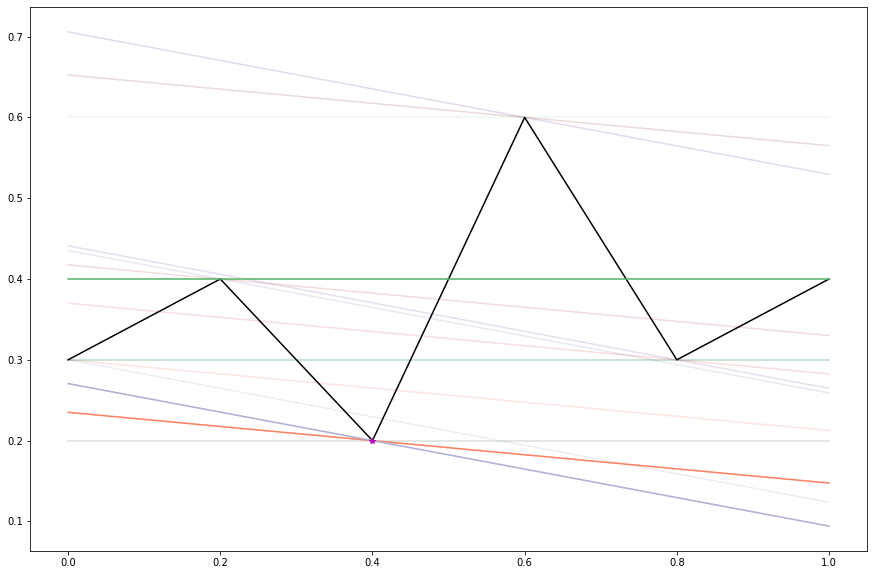

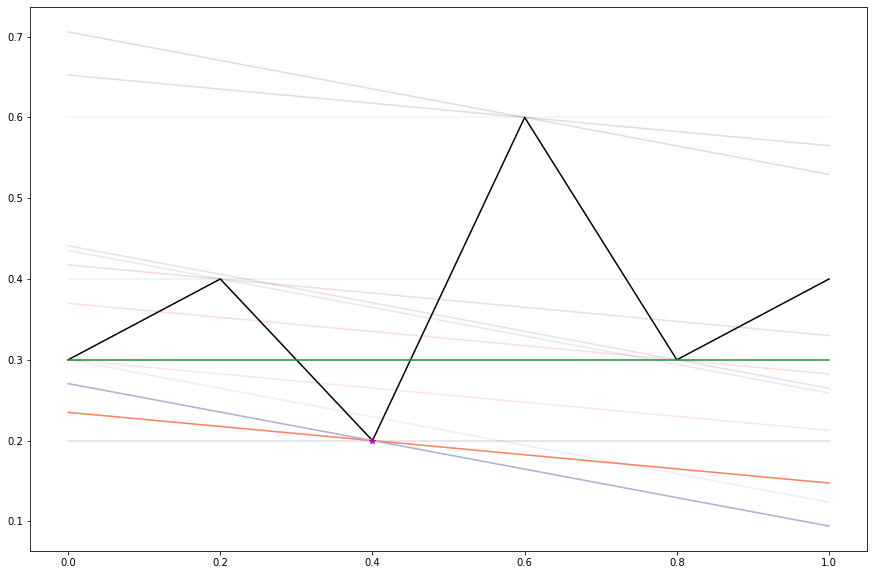

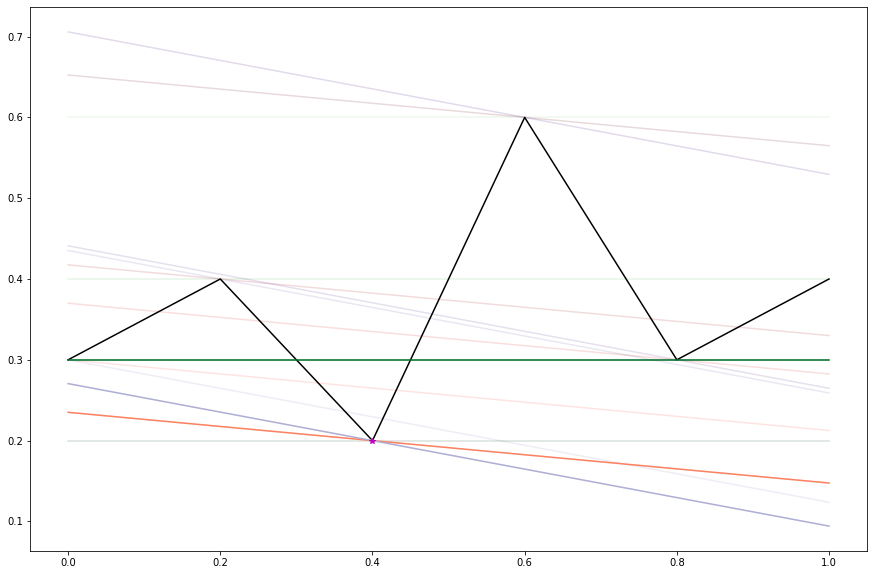

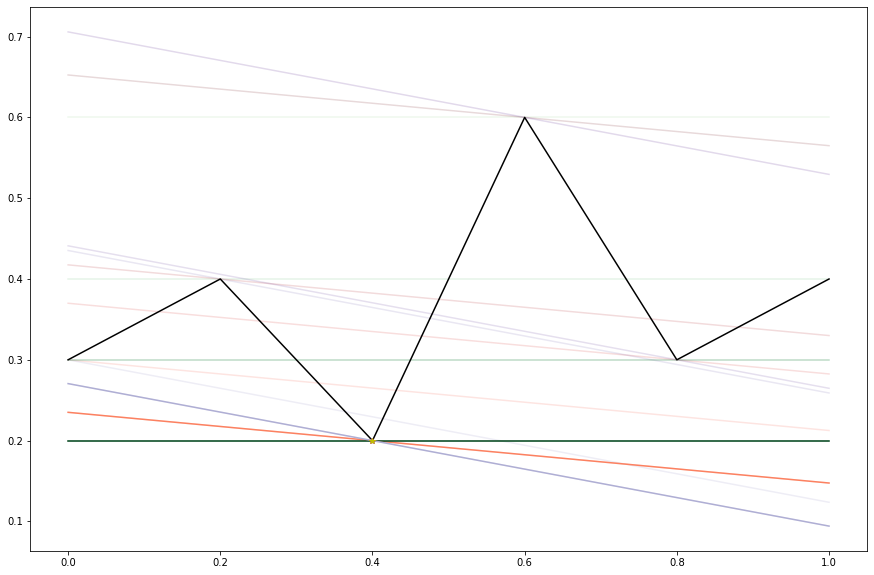

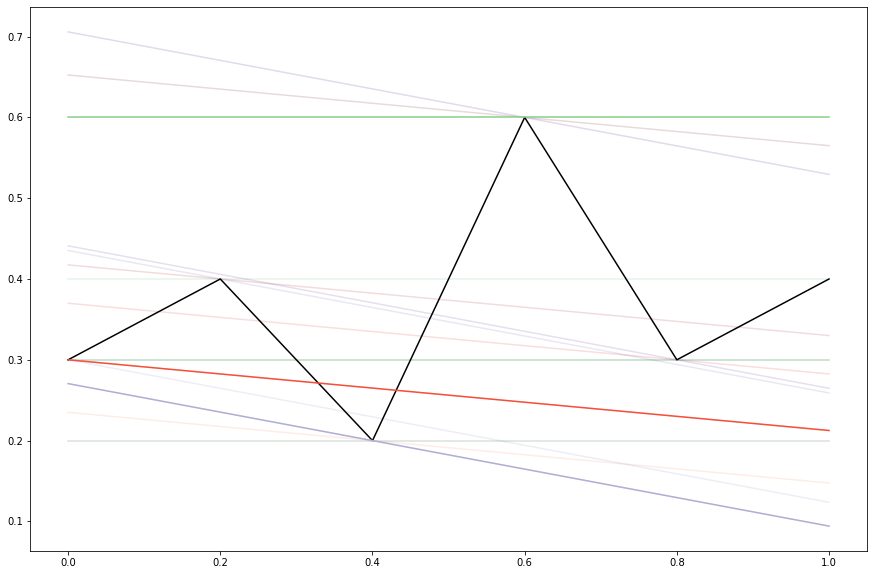

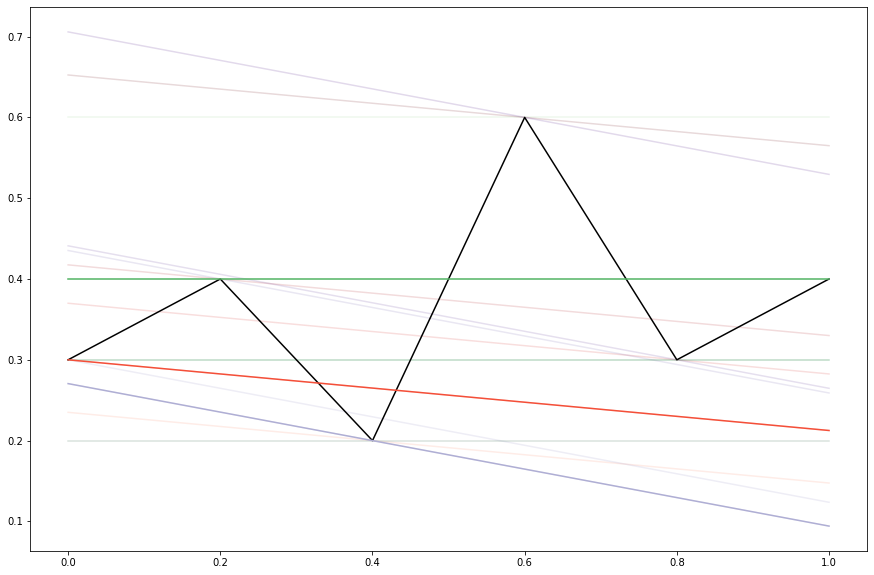

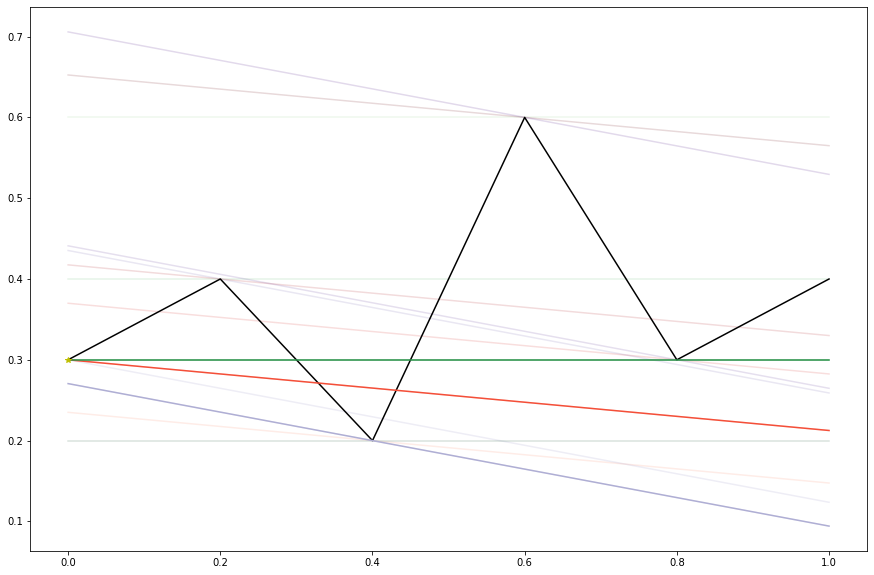

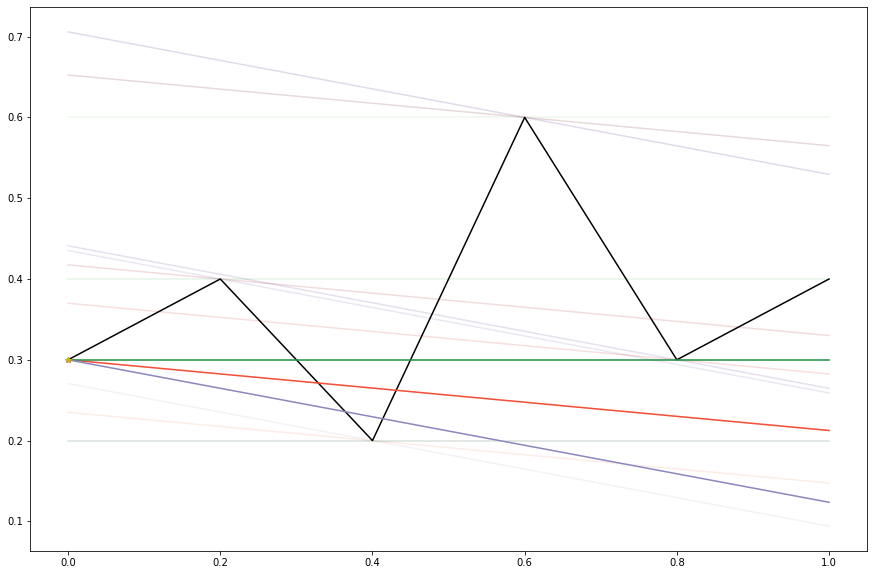

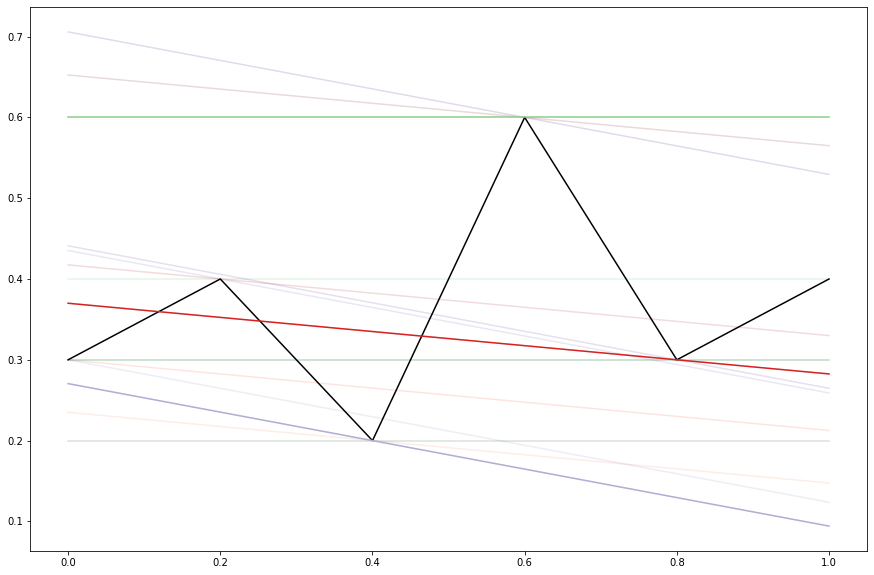

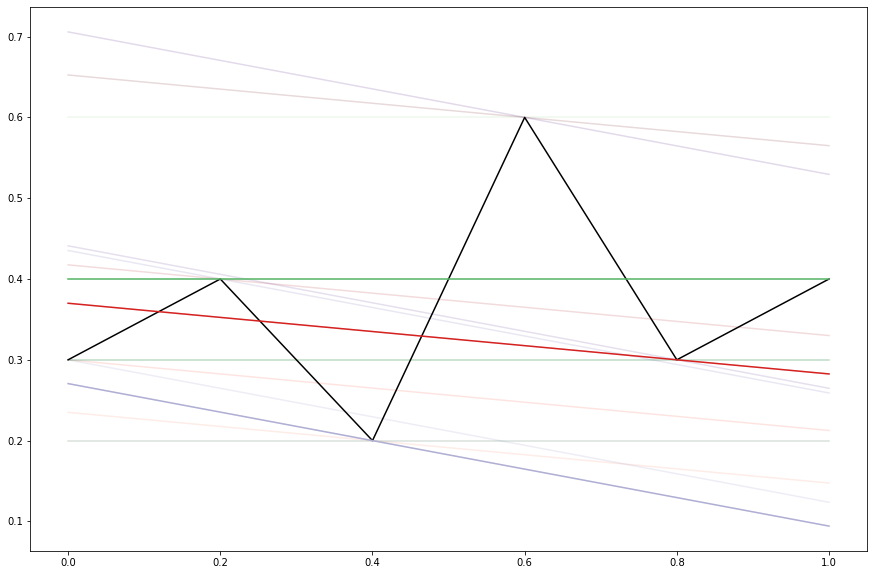

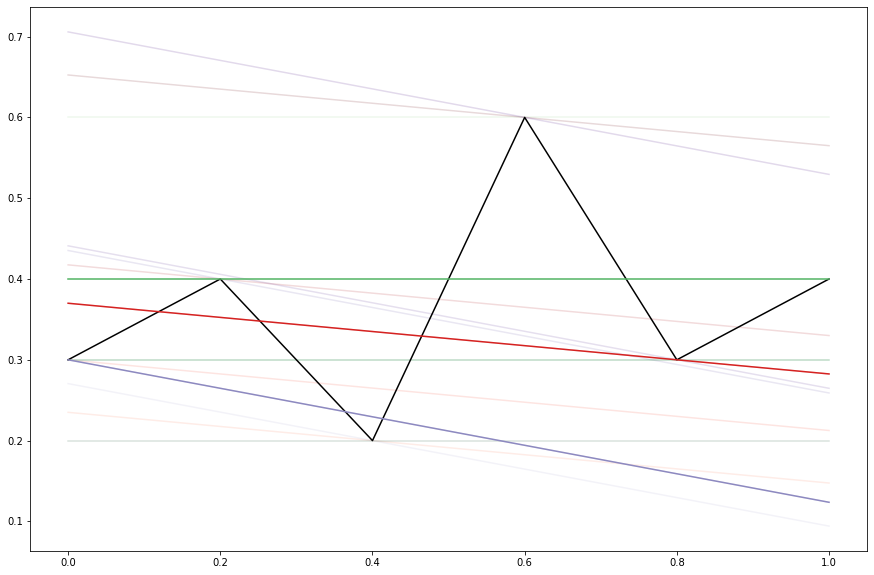

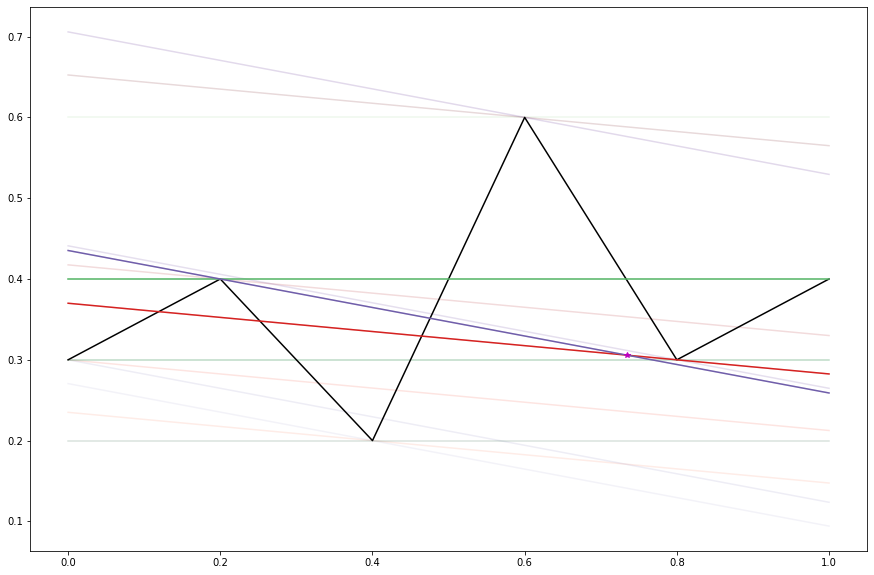

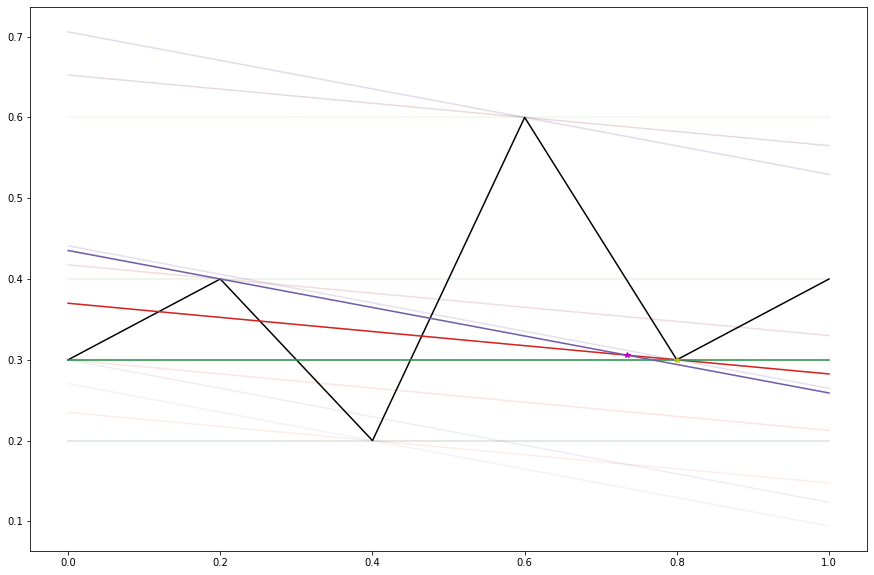

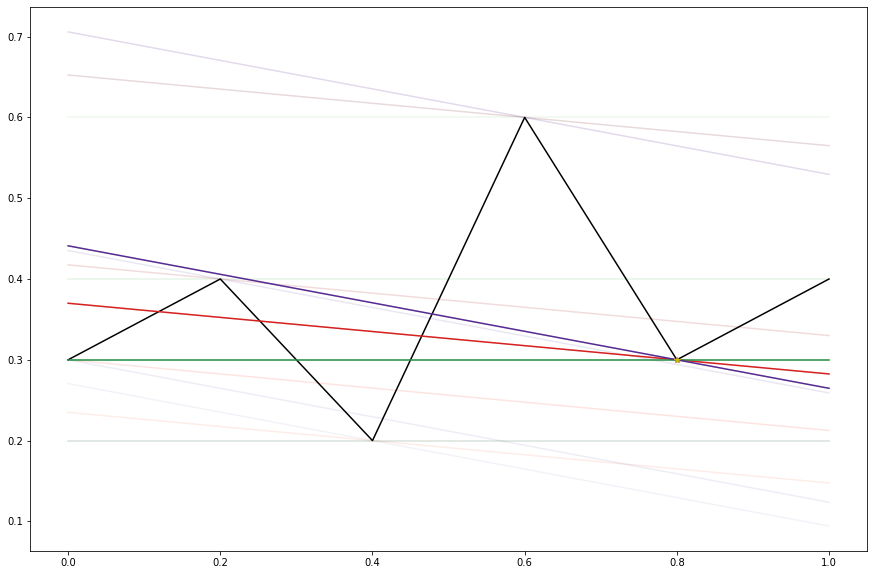

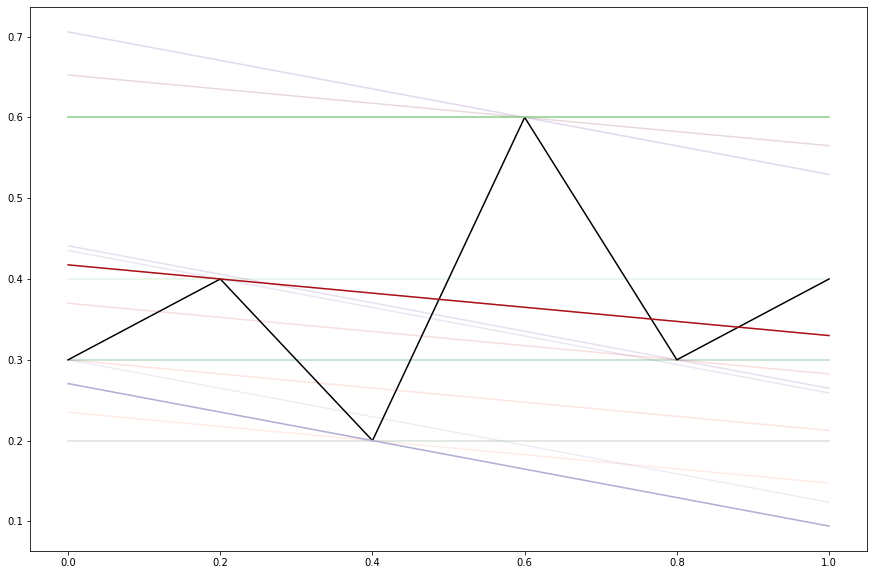

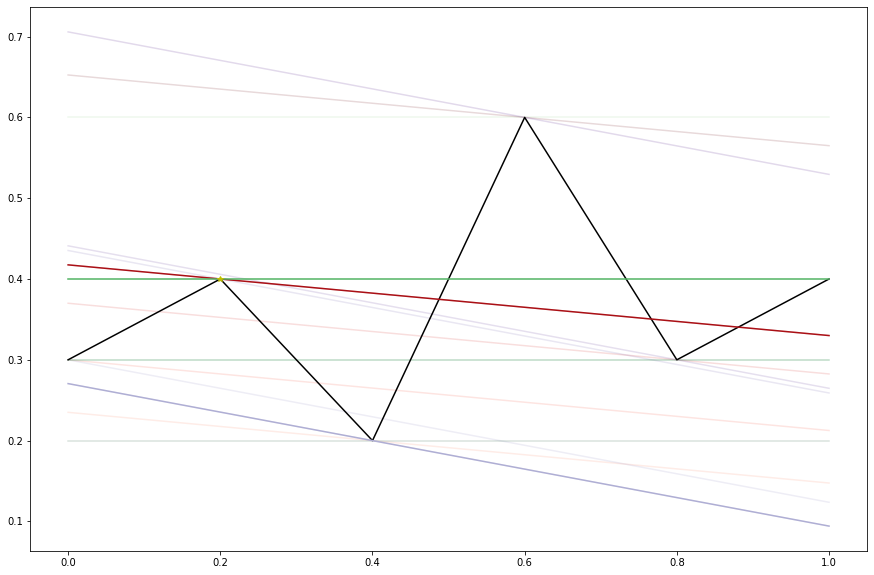

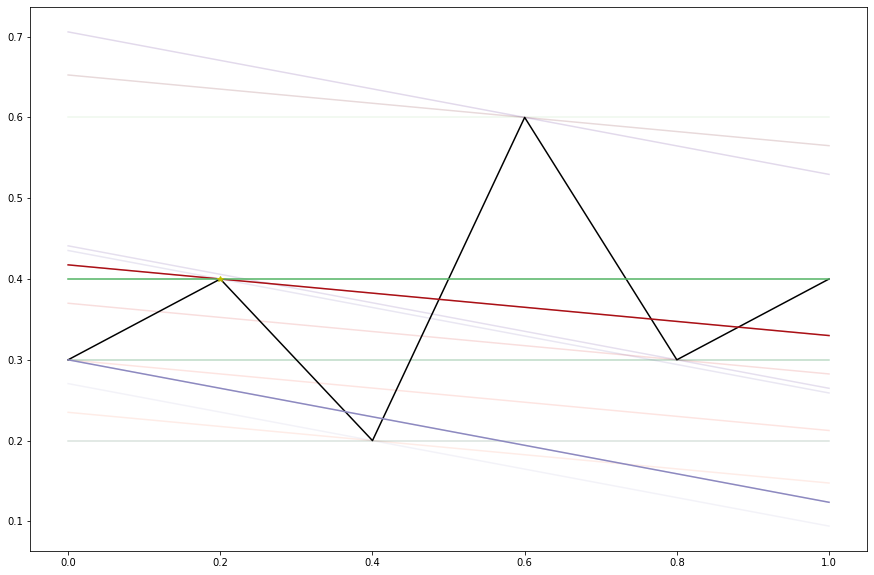

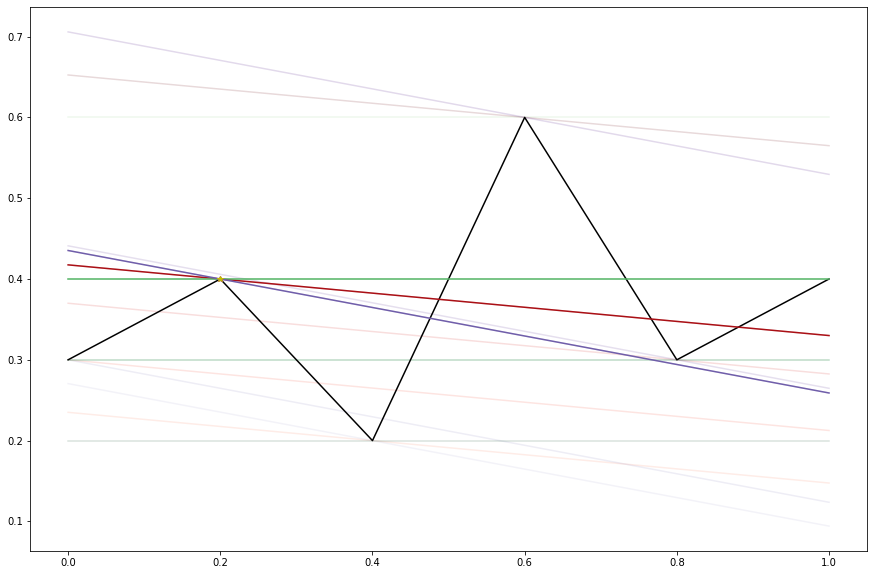

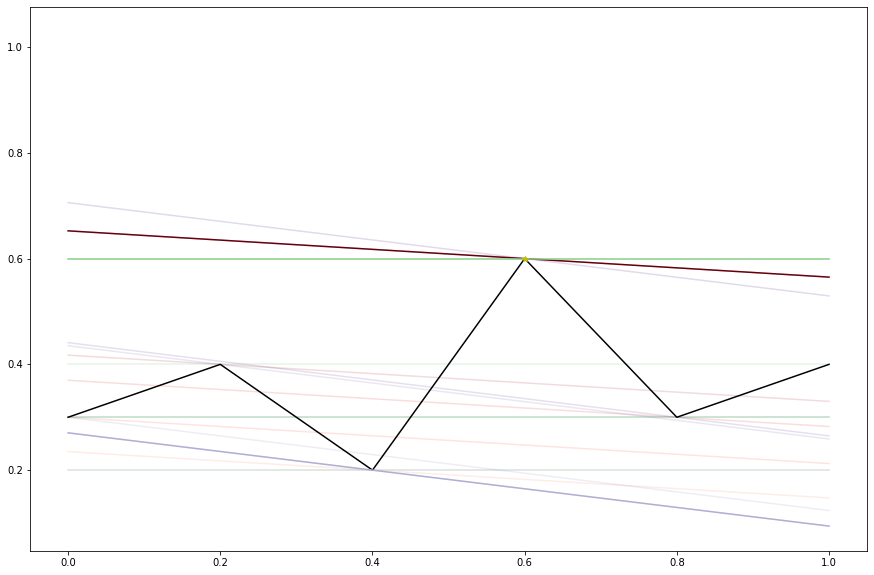

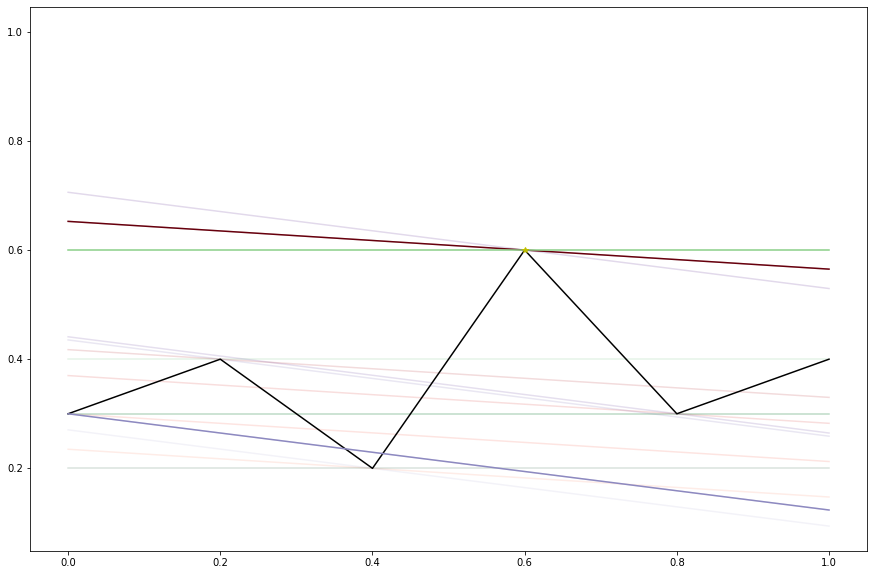

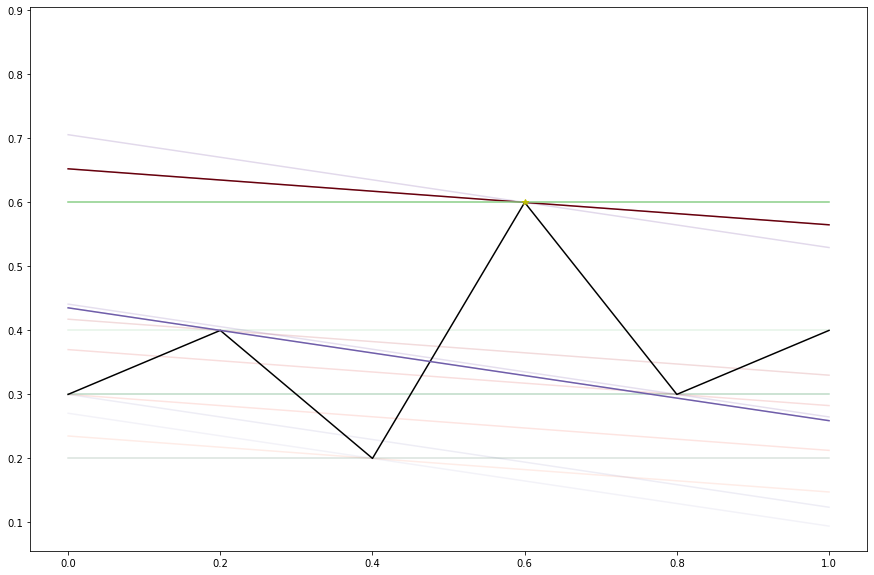

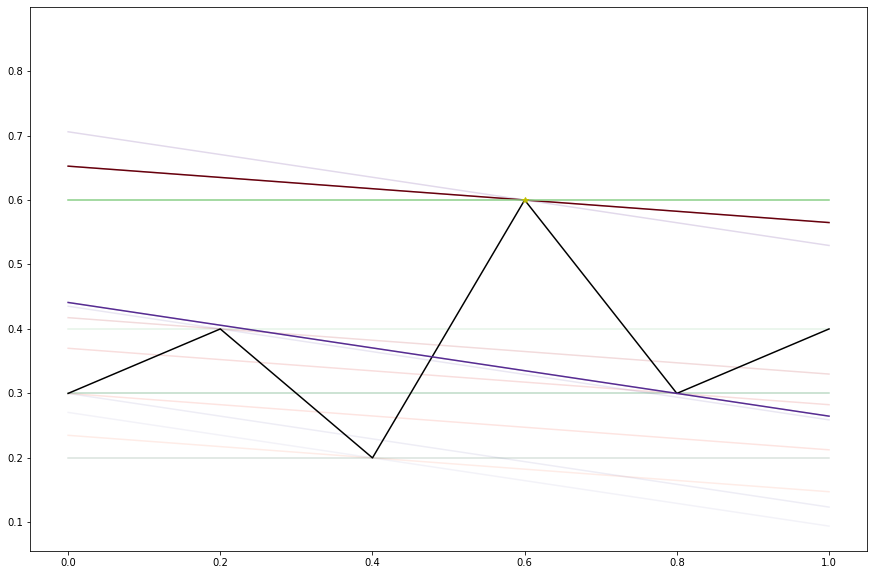

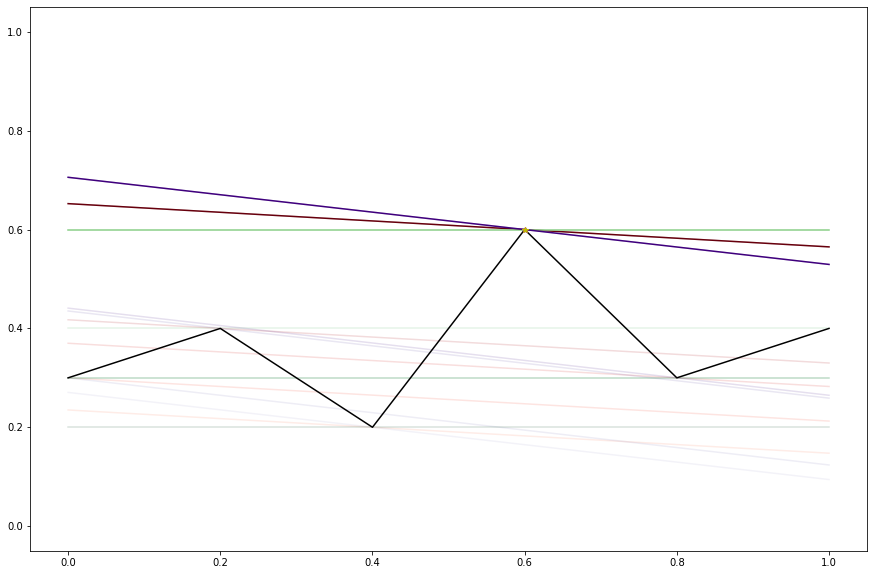

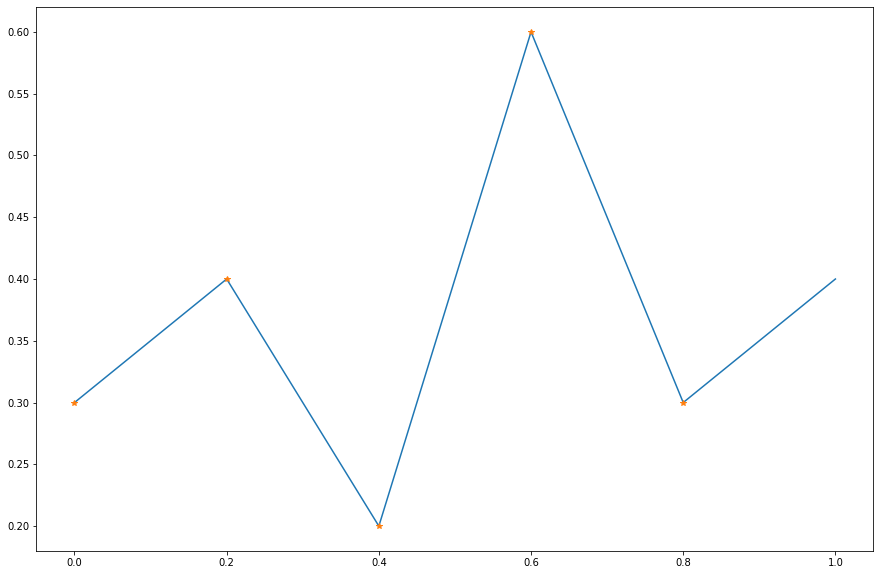

In [ ]:
X = [0.3, 0.4, 0.2, 0.6, 0.3, 0.4]
x = np.linspace(0, 1, len(X))

theta0 = 0
theta1 = 5 * np.pi / 180
theta2 = 10 * np.pi / 180
xx, yy = reconstruct_signal_step(X, x, theta0, theta1, theta2)
plt.figure(figsize=(15, 10))
plt.plot(x, X)
plt.plot(xx, yy, "*")
plt.show()